In [4]:
import pandas as pd
import numpy as np
import healpy as hp

from astropy.coordinates import SkyCoord
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 150

from collections import Counter

from datetime import date

import seaborn as sns
sns.set_context('poster')

In [5]:
import pandas as pd
import parameters_selection.exploring_script as es
import importlib
importlib.reload(es)
import matplotlib.pyplot as plt

from astropy.time import Time

In [11]:
cmap = 'Blues'
nside = 32

In [7]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

def ecl2equ(lon_ecl, lat_ecl):
    
    '''
    Transforms ecliptic coordinates to galactic ones.
    Then prepares them for matplotlib aitoff projection.
    '''
    
    ecl = SkyCoord(lon_ecl, lat_ecl, unit=u.deg, frame='barycentricmeanecliptic')
    equ = ecl.transform_to('fk5')

    # Minus appears because of “mapping from the inside” issue
    ra, dec = -equ.ra.wrap_at('180d').radian, equ.dec.radian
    
    return ra, dec

In [8]:
def plot_mwd(RA,Dec,color,ax, cmap='viridis', alpha=0.5, cb=True,org=0,title=None, cb_title='',projection='mollweide'):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -= 360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    cm = ax.scatter(
        np.radians(x),
        np.radians(Dec), 
        c=color,
        alpha=alpha,
        marker='.',
        cmap=cmap
    )  # convert degrees to radians
    if cb:
        cb = fig.colorbar(cm, orientation='horizontal', shrink=0.5)
        cb.set_label(cb_title)
        
    if title is not None:
        ax.set_title(title)
        
    tick_labels = np.array(['', '120', '', '60', '', '0', '', '300', '', '240', ''])
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)

In [9]:
def dec2theta(dec: float) -> float:
    """ Convert Dec (deg) to theta (rad)
    """
    return np.pi / 2.0 - np.pi / 180.0 * dec

def ra2phi(ra: float) -> float:
    """ Convert RA (deg) to phi (rad)
    """
    return np.pi / 180.0 * ra

def ang2pix(nside, ra, dec):
    return hp.ang2pix(
        nside,
        dec2theta(dec.values),
        ra2phi(ra.values)
    )

In [8]:
candidate_sso = es.load_candidate_data(['ra', 'dec'])
candidate_sso['pix'] = ang2pix(nside, candidate_sso['ra'], candidate_sso['dec'])
grouped = candidate_sso.groupby('pix').count()
grouped = grouped.reset_index()[['pix', 'ra']]
grouped = grouped.rename(columns={'ra': 'count'})
ra, dec = hp.pix2ang(nside, grouped['pix'].values, nest=False, lonlat=True)
resol = hp.nside2resol(nside, arcmin=True)

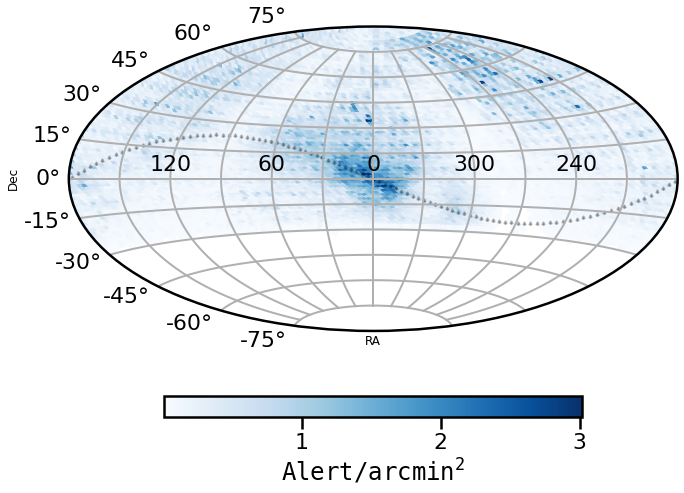

In [9]:
%matplotlib inline

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='aitoff')

plot_mwd(
    ra, 
    dec, 
    grouped['count'].values / resol, 
    ax=ax, 
#     title='2019-2022\n{:,} alerts\n'.format(np.sum(grouped['count'].values)), 
    cb_title=r'$\tt{Alert / arcmin}^2$',
    cmap=cmap,
    alpha=1.0,
    org=0
)

# Ecliptic plane
lon_ecl = np.linspace(0, 360, 100)
lat_ecl = np.zeros(100)

ra_ecl, dec_ecl = ecl2equ(lon_ecl, lat_ecl)

ax.scatter(ra_ecl, dec_ecl, s=4, marker='^', color='black', alpha=0.3)

plt.show()

# fig = plt.figure(figsize=(15, 8))
# map_ = np.zeros(12*64**2)
# map_[grouped['pix'].values] = grouped['count']
# map_[map_ == 0.0] = np.nan
# hp.mollview(map_, flip='astro', badcolor='white', cmap='Blues')
# hp.graticule()
# plt.show()

In [10]:
sso = es.load_data(['ra', 'dec', 'ssnamenr', 'jd'])
sso['pix'] = ang2pix(nside, sso['ra'], sso['dec'])

In [14]:
only_detectable = False

if only_detectable:
    # at least 6 nights
    c = sso.groupby('ssnamenr').count()
    c['flag'] = c['ra'] >= 6
    c = c.reset_index()
    sso = sso.merge(c[['ssnamenr', 'flag']])
    sso_six_pts = sso[sso['flag'] == True]

    # dt = 15 max
    d = sso_six_pts[['ssnamenr', 'jd']].groupby('ssnamenr').agg({'jd': list})
    d = d.reset_index()
    d['flag2'] = d['jd'].apply(lambda x: np.all(np.diff(np.sort(x)) < 15))

    sso = sso.merge(d[['ssnamenr', 'flag2']])
    sso_detectable = sso[sso['flag2'] == True]
else:
    sso_detectable = sso

In [15]:
grouped_sso = sso_detectable.groupby('pix').count()
grouped_sso = grouped_sso.reset_index()[['pix', 'ra']]
grouped_sso = grouped_sso.rename(columns={'ra': 'count'})
ra, dec = hp.pix2ang(nside, grouped_sso['pix'].values, nest=False, lonlat=True)
resol = hp.nside2resol(nside, arcmin=True)

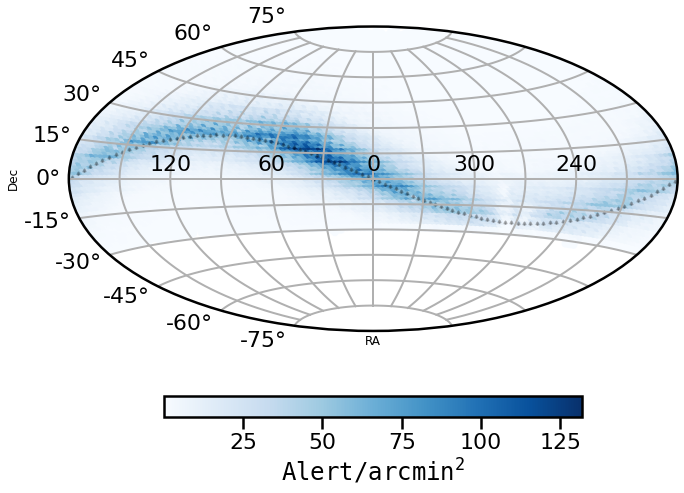

In [16]:
%matplotlib inline

fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(111, projection='aitoff')

plot_mwd(
    ra, 
    dec, 
    grouped_sso['count'].values / resol, 
    ax=ax, 
#     title='2019-2022\n{:,} alerts\n'.format(np.sum(grouped_sso['count'].values)), 
    cb_title=r'$\tt{Alert / arcmin}^2$',
    cmap=cmap,
    alpha=1.0,
    org=0
)

# Ecliptic plane
lon_ecl = np.linspace(0, 360, 100)
lat_ecl = np.zeros(100)

ra_ecl, dec_ecl = ecl2equ(lon_ecl, lat_ecl)

ax.scatter(ra_ecl, dec_ecl, s=4, marker='^', color='black', alpha=0.3)

plt.show()

# fig = plt.figure(figsize=(15, 8))
# map_ = np.zeros(12*64**2)
# map_[grouped_sso['pix'].values] = grouped_sso['count']
# map_[map_ == 0.0] = np.nan
# hp.mollview(map_, flip='astro', badcolor='white', cmap='Blues')
# hp.graticule()
# plt.show()

In [17]:
import io
import requests
import pandas as pd

r = requests.post(
  'https://fink-portal.org/api/v1/ssocand',
  json={
    'kind': 'lightcurves'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

pdf['pix'] = ang2pix(nside, pdf['d:ra'], pdf['d:dec'])
grouped_traj = pdf.groupby('pix').count()
grouped_traj = grouped_traj.reset_index()[['pix', 'd:ra']]
grouped_traj = grouped_traj.rename(columns={'d:ra': 'count'})
ra, dec = hp.pix2ang(nside, grouped_traj['pix'].values, nest=False, lonlat=True)
resol = hp.nside2resol(nside, arcmin=True)

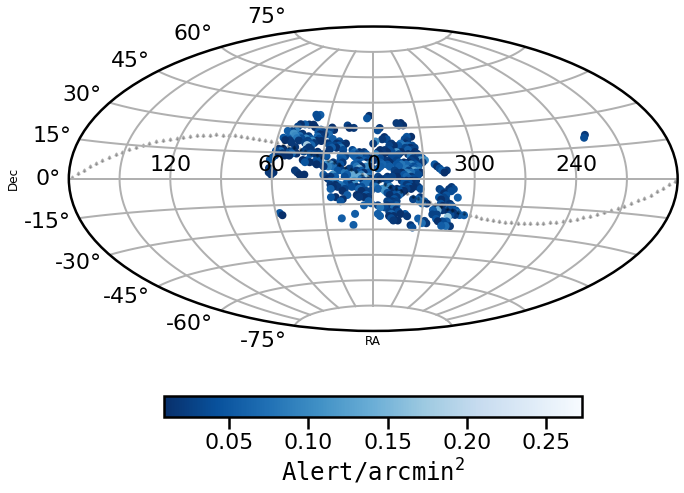

In [18]:
%matplotlib inline

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='aitoff')

plot_mwd(
    ra, 
    dec, 
    grouped_traj['count'].values / resol, 
    ax=ax, 
#     title='2019-2022\n{:,} alerts\n'.format(np.sum(grouped_traj['count'].values)), 
    cb_title=r'$\tt{Alert / arcmin}^2$',
    cmap=cmap+'_r',
    alpha=1.0,
    org=0
)

# Ecliptic plane
lon_ecl = np.linspace(0, 360, 100)
lat_ecl = np.zeros(100)

ra_ecl, dec_ecl = ecl2equ(lon_ecl, lat_ecl)

ax.scatter(ra_ecl, dec_ecl, s=4, marker='^', color='black', alpha=0.3)

plt.show()

# fig = plt.figure(figsize=(15, 8))
# map_ = np.zeros(12*64**2)
# map_[grouped_traj['pix'].values] = grouped_traj['count']
# map_[map_ == 0.0] = np.nan
# hp.mollview(map_, flip='astro', badcolor='white', cmap='Blues')
# hp.graticule()
# plt.show()

In [12]:
resol

109.93556517815699

In [1]:
import io
import requests
import pandas as pd

In [2]:
r_lc = requests.post(
  'https://fink-portal.org/api/v1/ssocand',
  json={
    'kind': "lightcurves", # Mandatory, `orbParams` or `lightcurves`
    # 'ssoCandId': int, # optional, if you know a trajectory ID. Otherwise returns all.
    # 'start_date': str, # optional. Only for lightcurves. Default is 2019-11-01
    # 'stop_date': str, # optional. Only for lightcurves. Default is today.
    # 'output-format': str
    'maxnumber': 15000
  }
)

# Format output in a DataFrame
pdf_lc = pd.read_json(io.BytesIO(r_lc.content)).sort_values(["d:ssoCandId", "d:jd"])
pdf_lc

,d:assoc_tag,d:candid,d:dec,d:fid,d:jd,d:magpsf,d:nid,d:objectId,d:ra,d:sigmapsf,d:ssoCandId
11998,I,2476372023315015024,13.081433,2,2.460231e+06,17.167105,2476,ZTF23abjovyv,38.919989,0.038061,FF04112023aaaacti
12000,I,2476378843315015021,13.081166,1,2.460231e+06,17.757242,2476,ZTF23abjphna,38.919244,0.067864,FF04112023aaaacti
12008,A,2482327453615015018,12.870181,2,2.460237e+06,17.108437,2482,ZTF23ablrlxa,38.238813,0.044484,FF04112023aaaacti
12014,A,2487400923815015000,12.682060,2,2.460242e+06,17.025036,2487,ZTF23abnbdkc,37.621703,0.039644,FF04112023aaaacti
12016,A,2496209324315015004,12.349785,1,2.460251e+06,17.637896,2496,ZTF23abofdlw,36.511430,0.052509,FF04112023aaaacti
...,...,...,...,...,...,...,...,...,...,...,...
11968,I,2427464595815015002,14.544699,2,2.460182e+06,16.756470,2427,ZTF23aaztxjt,42.432385,0.013706,FF31082023aaaactb
11971,T,2431361575815015011,14.552781,2,2.460186e+06,16.723260,2431,ZTF23abakxsy,42.575703,0.016129,FF31082023aaaactb
11972,T,2431460825815015006,14.552960,1,2.460186e+06,17.171831,2431,ZTF23abameay,42.578580,0.020825,FF31082023aaaactb
11974,T,2433421885815015000,14.554494,2,2.460188e+06,16.746605,2433,ZTF23abarxae,42.634855,0.027243,FF31082023aaaactb


In [12]:
pdf_lc['pix'] = ang2pix(nside, pdf_lc['d:ra'], pdf_lc['d:dec'])
grouped_traj = pdf_lc.groupby('pix').count()
grouped_traj = grouped_traj.reset_index()[['pix', 'd:ra']]
grouped_traj = grouped_traj.rename(columns={'d:ra': 'count'})
ra, dec = hp.pix2ang(nside, grouped_traj['pix'].values, nest=False, lonlat=True)
resol = hp.nside2resol(nside, arcmin=True)

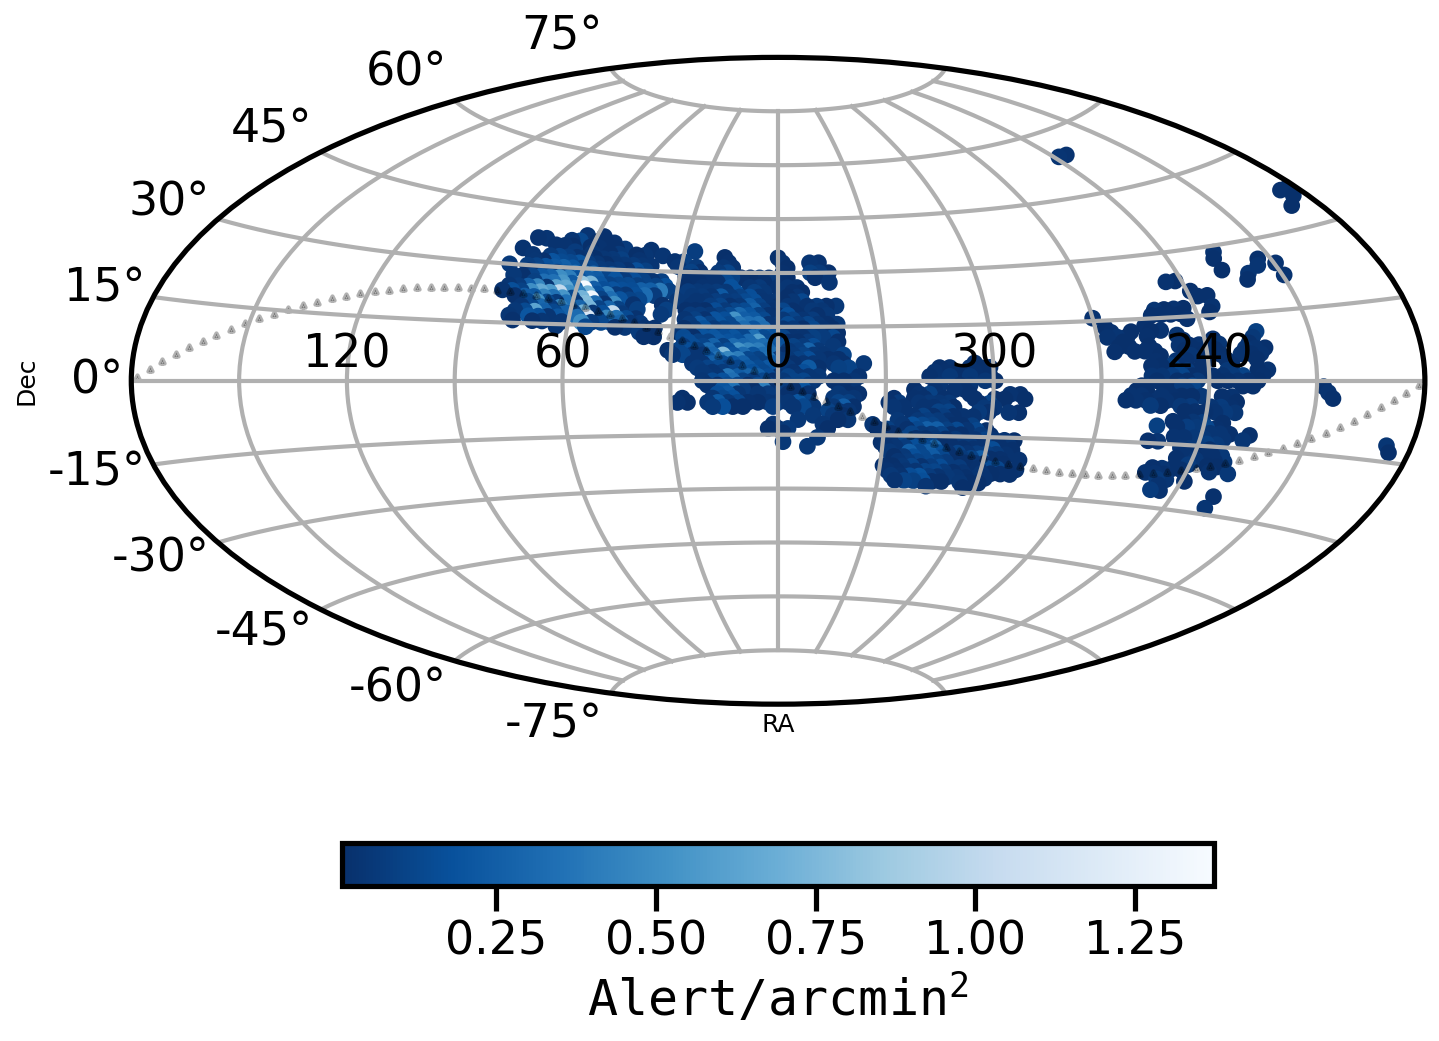

In [13]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='aitoff')

plot_mwd(
    ra, 
    dec, 
    grouped_traj['count'].values / resol, 
    ax=ax, 
#     title='2019-2022\n{:,} alerts\n'.format(np.sum(grouped_traj['count'].values)), 
    cb_title=r'$\tt{Alert / arcmin}^2$',
    cmap=cmap+'_r',
    alpha=1.0,
    org=0
)

# Ecliptic plane
lon_ecl = np.linspace(0, 360, 100)
lat_ecl = np.zeros(100)

ra_ecl, dec_ecl = ecl2equ(lon_ecl, lat_ecl)

ax.scatter(ra_ecl, dec_ecl, s=4, marker='^', color='black', alpha=0.3)

plt.show()

In [15]:
pdf_lc["day"] = pdf_lc["d:jd"].astype(int)

In [19]:
pdf_lc.groupby("day").count()

,d:assoc_tag,d:candid,d:dec,d:fid,d:jd,d:magpsf,d:nid,d:objectId,d:ra,d:sigmapsf,d:ssoCandId,pix
day,,,,,,,,,,,,
2460043,1,1,1,1,1,1,1,1,1,1,1,1
2460045,3,3,3,3,3,3,3,3,3,3,3,3
2460049,1,1,1,1,1,1,1,1,1,1,1,1
2460050,2,2,2,2,2,2,2,2,2,2,2,2
2460052,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2460236,2,2,2,2,2,2,2,2,2,2,2,2
2460238,3,3,3,3,3,3,3,3,3,3,3,3
2460241,3,3,3,3,3,3,3,3,3,3,3,3
